In [ ]:
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.optimize import minimize
from sklearn.covariance import GraphicalLassoCV

import networkx as nx

import learnHeat as lh

# data importation
atlas = datasets.fetch_atlas_msdl()
atlas_filename = atlas.maps

data = datasets.fetch_development_fmri(n_subjects=1)
fmri_filename = data.func[0]

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True, verbose=5)
time_series = masker.fit_transform(fmri_filename)

X = time_series.T 
print(f"Forme de la matrice X : {X.shape}")

[fetch_atlas_msdl] Dataset found in C:\Users\victo\nilearn_data\msdl_atlas

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri\development_fmri

[fetch_development_fmri] Dataset found in C:\Users\victo\nilearn_data\development_fmri\development_fmri

[NiftiMapsMasker.wrapped] Loading regions from ...\msdl_rois.nii

[NiftiMapsMasker.wrapped] Resampling regions

[NiftiMapsMasker.wrapped] Finished fit

[NiftiMapsMasker.wrapped] Loading data from sub-pixar123_task-...

[NiftiMapsMasker.wrapped] Extracting region signals

[NiftiMapsMasker.wrapped] Cleaning extracted signals

Forme de la matrice X : (39, 168)


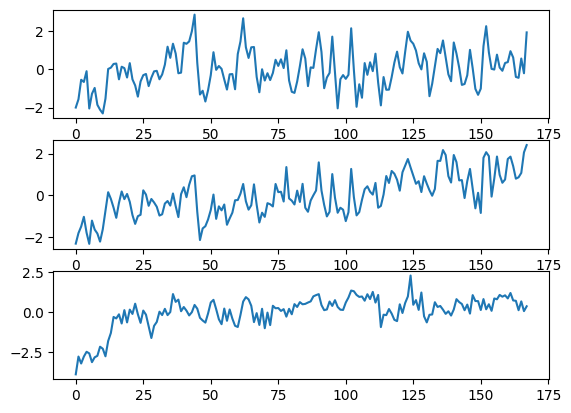

In [ ]:
# Testing the imported data
x0 = X[0,:]
x1 = X[1,:]
x2 = X[20,:]

plt.subplot(3,1,1)
plt.plot(x0)
plt.subplot(3,1,2)
plt.plot(x1)
plt.subplot(3,1,3)
plt.plot(x2)
plt.show()

### Statistical method - II-A of the article

c:\Users\victo\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


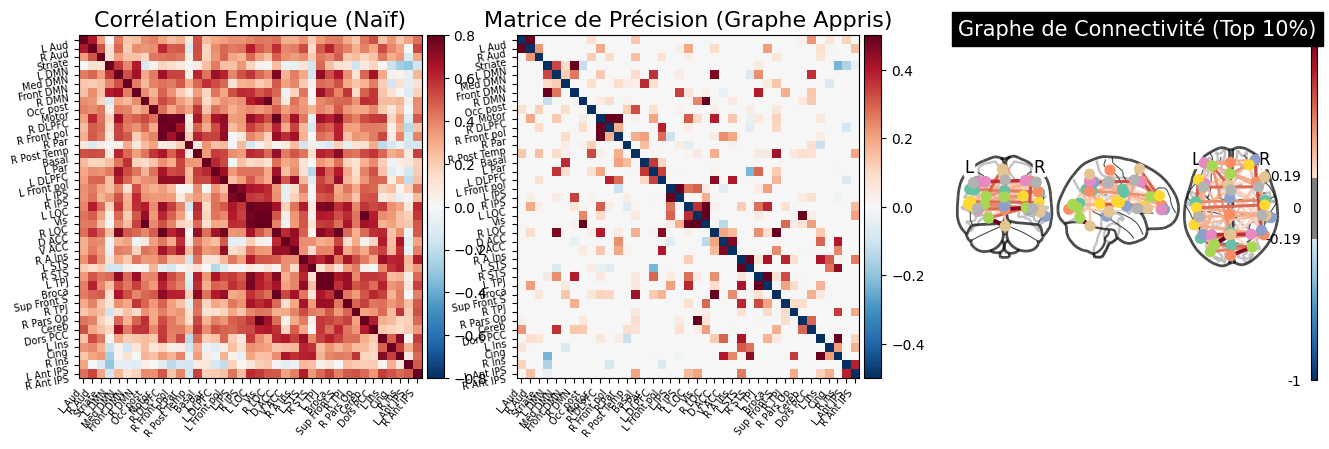

In [28]:
# We use the Graphical Lasso method
gl_model = GraphicalLassoCV(cv=5, max_iter=1000)
gl_model.fit(time_series)

precision_matrix = gl_model.precision_
covariance_matrix = gl_model.covariance_


# Plotting 
coords = atlas.region_coords

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Correlation between the time series at each node
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
plotting.plot_matrix(correlation_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.8, vmin=-0.8, axes=axes[0], title="Corrélation Empirique (Naïf)")

# Plotting the adjacency matrix constructed by this method and the associated connectome
plotting.plot_matrix(-precision_matrix, labels=atlas.labels, colorbar=True,
                     vmax=0.5, vmin=-0.5, axes=axes[1], title="Matrice de Précision (Graphe Appris)")

plotting.plot_connectome(-precision_matrix, coords,
                         edge_threshold='90%', title="Graphe de Connectivité (Top 10%)",
                         axes=axes[2])
plt.show()

### Method based on global smoothness - IIIA of the article 

In [23]:
n_nodes = X.shape[0]

dist_matrix_sq = squareform(pdist(X, metric='sqeuclidean'))
idx_upper = np.triu_indices(n_nodes, k=1)

def graph_learning_objective(w_vector, dist_sq, beta):
    """
    Fonction objectif : Smoothness + Régularisation
    J(L) = tr(X.T * L * X) + beta * ||L||_F^2
    """
    W = np.zeros((n_nodes, n_nodes))
    W[idx_upper] = w_vector
    W = W + W.T
    
    degrees = np.sum(W, axis=1)
    L = np.diag(degrees) - W
    
    smoothness = np.sum(w_vector * dist_sq[idx_upper])
    regularization = np.sum(L**2)
    
    return smoothness + beta * regularization

def constraint_trace(w_vector):
    # The sum of the degrees is equal to 2 times the sum of the weights of the edges 
    return 2 * np.sum(w_vector) - n_nodes


# Setting up the optimization framework
beta_param = [0.1, 0.5, 1, 5, 10]  
initial_guess = np.ones(len(idx_upper[0])) * (n_nodes / (2 * len(idx_upper[0]))) 
bounds = [(0, None) for _ in range(len(initial_guess))] 
constraints = [{'type': 'eq', 'fun': constraint_trace}]

# Testing the optimization for different regularization parameters beta 
W_result = []
for beta in beta_param:
    result = minimize(
        graph_learning_objective, 
        initial_guess, 
        args=(dist_matrix_sq, beta),
        method='SLSQP', 
        bounds=bounds, 
        constraints=constraints,
        options={'maxiter': 1000, 'disp': True}
    )

    w_opt = result.x
    W_gsp = np.zeros((n_nodes, n_nodes))
    W_gsp[idx_upper] = w_opt
    W_gsp = W_gsp + W_gsp.T

    W_result.append(W_gsp)


Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 987.5460672843819
            Iterations: 8
            Function evaluations: 2968
            Gradient evaluations: 4
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1157.4985042973478
            Iterations: 13
            Function evaluations: 6682
            Gradient evaluations: 9
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1293.3432284370508
            Iterations: 23
            Function evaluations: 14130
            Gradient evaluations: 19
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 1880.5177051839155
            Iterations: 52
            Function evaluations: 35711
            Gradient evaluations: 48
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 2321.458474660

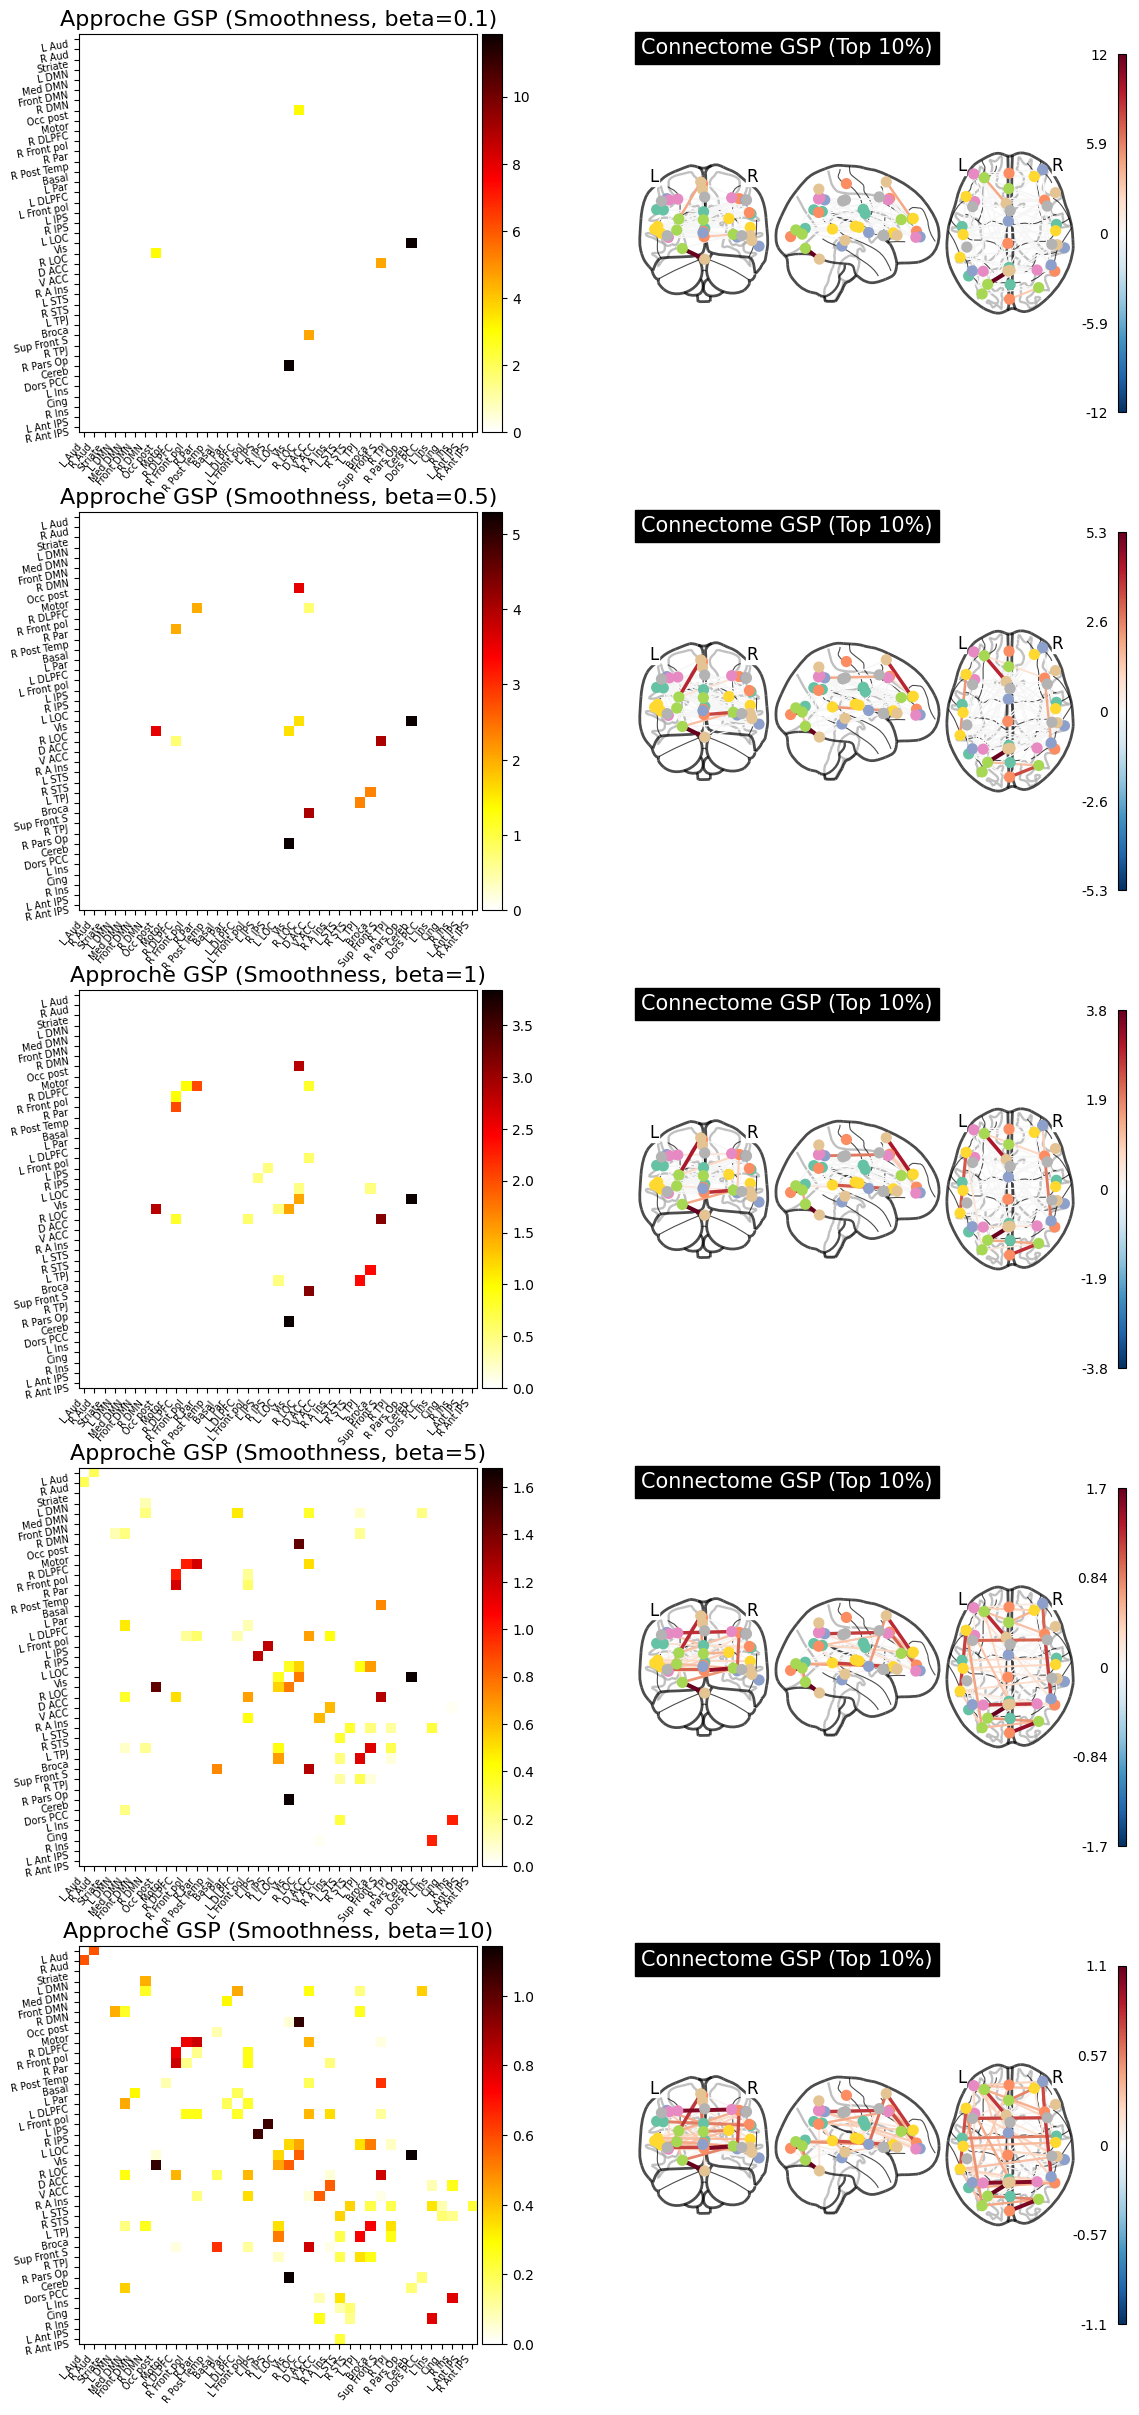

In [25]:
# Plot 
fig, axes = plt.subplots(5, 2, figsize=(14, 30))
for i, beta in enumerate(beta_param): 
    plotting.plot_matrix(W_result[i], labels=atlas.labels, colorbar=True, cmap='hot_r',
                        axes=axes[i, 0], title=f"Approche GSP (Smoothness, beta={beta})")

    plotting.plot_connectome(W_result[i], atlas.region_coords, edge_threshold='90%', 
                            axes=axes[i, 1], title="Connectome GSP (Top 10%)")
plt.show()

### Spectral filtering - IIIB of the article 

#### Stationarity based 

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.929279440296498e-14
            Iterations: 3
            Function evaluations: 120
            Gradient evaluations: 3


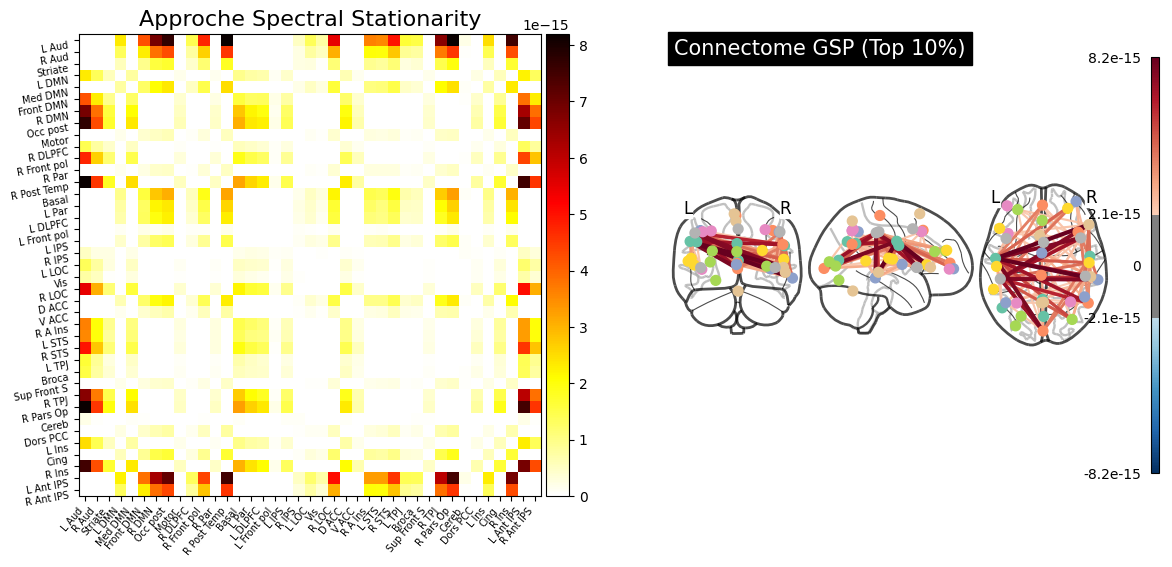

In [37]:
empirical_covariance_matrix = np.cov(X)
_, chi = np.linalg.eigh(empirical_covariance_matrix)

n_nodes = X.shape[0]
idx_upper = np.triu_indices(n_nodes, k=1)

def graph_learning_objective(lambda_vector):
    """
    Fonction objectif : 
    J(L) = ||L||_F^2 
    """
    return np.linalg.norm(lambda_vector)

def constraint_w(lambda_vector):
    L = chi@np.diag(lambda_vector)@chi.T
    w_vector = -L[idx_upper]
    return w_vector # We want positive edge weights

def constraint_d(lambda_vector):
    L = chi@np.diag(lambda_vector)@chi.T
    D = np.identity(n_nodes)*L
    W = D-L
    return np.sum(W, axis=1)-[D[i,i] for i in range(n_nodes)] # We want the degrees to correspond to the edge weights

# def constraint_trace(lambda_vector):
#     return np.sum(lambda_vector)-n_nodes

initial_guess = np.ones(n_nodes)
bounds = [(0, None) for _ in range(len(initial_guess))] 
constraints = [
    {'type': 'ineq', 'fun': constraint_w},
    {'type': 'eq', 'fun': constraint_d}, 
    # {'type': 'eq', 'fun': constraint_trace}
]

result = minimize(
    graph_learning_objective, 
    initial_guess, 
    method='SLSQP', 
    bounds=bounds,
    constraints=constraints,
    options={'maxiter': 1000, 'disp': True}
)

lambda_opt = result.x
L = chi@np.diag(lambda_opt)@chi.T
D = np.identity(n_nodes)*L
W = D-L

# We only keep the positive edge weights 
threshold = 0
W = np.maximum(W-threshold, 0)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plotting.plot_matrix(W, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche Spectral Stationarity")

plotting.plot_connectome(W, atlas.region_coords, edge_threshold='90%', 
                         axes=axes[1], title="Connectome GSP (Top 10%)")
plt.show()

#### Graph dictionary based

In [40]:
n_nodes = X.shape[0]

rg = nx.fast_gnp_random_graph(n_nodes, p = 0.4)
L0 = nx.laplacian_matrix(rg).toarray()
L0 = L0/np.trace(L0)*n_nodes
tau0 = [1, 2]
H0 = np.random.rand(lh.D(L0, tau0).shape[1], X.shape[1])

# alpha_values = [1e-2, 1e-1, 1]
# beta_values = [1e-2, 1e-1, 1]


result = lh.learn_heat(X = X, 
            L0=L0, H0 = H0, tau0=tau0, 
            verbose=False, 
            max_iter = 50, alpha=.1, beta=.1)


Learning progress: 100%|██████████| 50/50 [04:32<00:00,  5.44s/it]
COST: 532.23038 (tau updated)


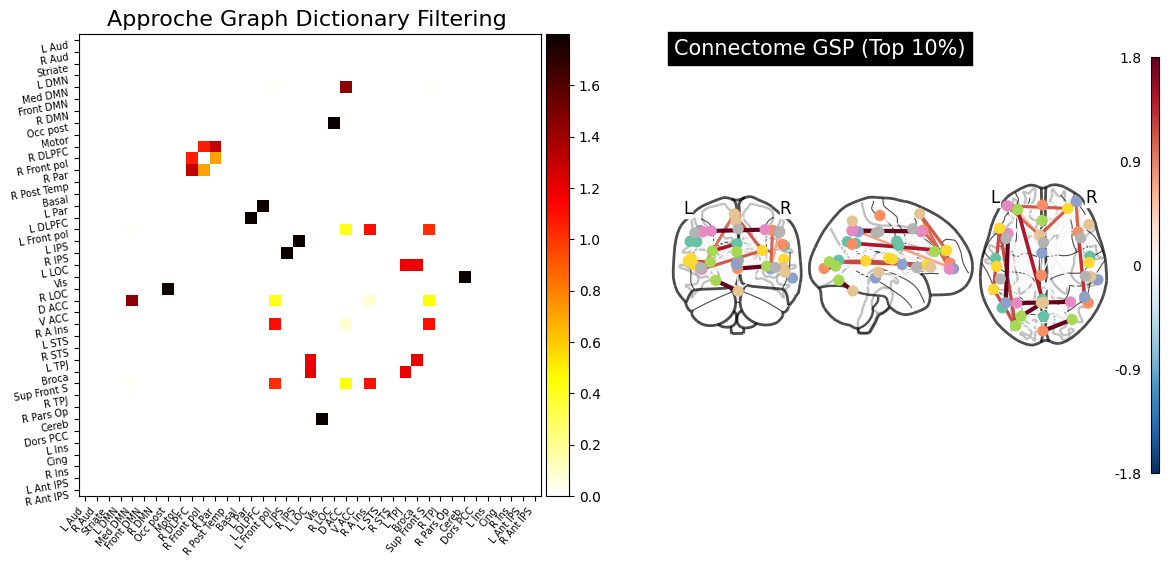

In [41]:
laplacian_matrix = result['L']
mask_diagonal = np.ones_like(laplacian_matrix) - np.identity(laplacian_matrix.shape[0])
adjacency_matrix = - laplacian_matrix*mask_diagonal


fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plotting.plot_matrix(adjacency_matrix, labels=atlas.labels, colorbar=True, cmap='hot_r',
                     axes=axes[0], title=f"Approche Graph Dictionary Filtering ")

plotting.plot_connectome(adjacency_matrix, atlas.region_coords, edge_threshold='90%', 
                         axes=axes[1], title="Connectome GSP (Top 10%)")
plt.show()